## Module 2 : Augmented ISEAR DATA Processing with Ensembles

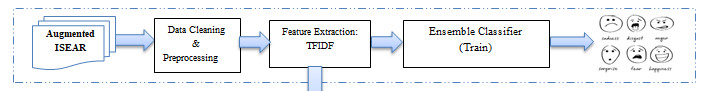

In [4]:
from PIL import Image
Image.open("arc_2.png")

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from nltk.tokenize import word_tokenize
import re
import nltk
#http://rasbt.github.io/mlxtend/
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

### 1. Loading the data

In [12]:
# bad lines wih too much commas will be dropped
data = pd.read_csv("data/isear_100p_augmented.csv" )

In [13]:
data.head()

,ID,CITY,COUN,SUBJ,SEX,AGE,RELI,PRAC,FOCC,MOCC,...,RELA,VERBAL,NEUTRO,Field1,Field3,Field2,MYKEY,SIT,STATE,Unnamed: 42
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,guilt,NaN,NaN,NaN,"whilst had an argument with inmy daughter, ive...",NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,disgust,NaN,NaN,NaN,few invested_enterprises_fies students practic...,NaN,NaN
2,301033.0,1.0,30.0,33.0,2.0,21.0,8.0,0.0,4.0,4.0,...,2.0,2.0,0.0,joy,2.0,2.0,3010331.0,I got better marks in the examn than many arro...,1.0,NaN
3,201077.0,1.0,20.0,77.0,1.0,19.0,6.0,2.0,8.0,1.0,...,3.0,3.0,2.0,anger,3.0,4.0,2010773.0,When a kid dropped my father's radio cassette ...,1.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,sadness,NaN,NaN,NaN,when tho returned those my friends at elementa...,NaN,NaN


In [14]:
 data.shape # gives the shape of the dataset

(18211, 43)

In [15]:
from sklearn.utils import shuffle

X = data["SIT"]                  #setting X as Sentence column data , neglating all the remianing columns
Y = data["Field1"]

In [16]:
X.shape , Y.shape

((18211,), (18211,))

In [17]:
emotions = Y.unique()
emotions

array(['guilt', 'disgust', 'joy', 'anger', 'sadness', 'fear', 'shame'],
      dtype=object)

In [7]:
Y.value_counts()

sadness    2654
shame      2636
disgust    2635
guilt      2614
fear       2589
anger      2562
joy        2521
Name: Field1, dtype: int64

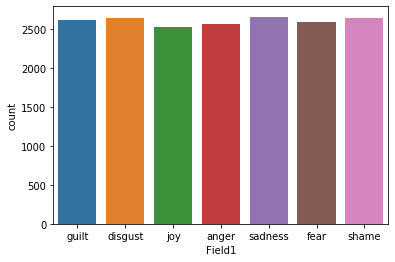

In [8]:
#grahical representation
sns.countplot(x=Y, data=data);

### 2. Word Cloud Representation

In [9]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# iterate through the csv file 
complete_words = '' 
for val in data.SIT:  
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    complete_words += " ".join(tokens)+" "

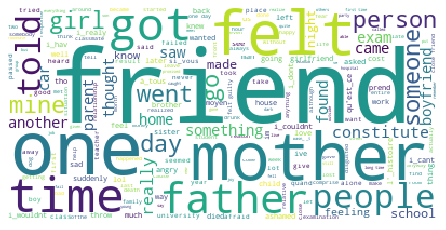

In [10]:
#Creating Word Cloud
from wordcloud import WordCloud
plt.figure()
text = str(complete_words )
wordcloud = WordCloud(background_color='white').generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

### 3. Splitting the data into train and test

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

In [12]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14568,) (14568,)
(3643,) (3643,)


### 4. Preprocessing

In [13]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)      # replace won't with "will not"
    phrase = re.sub(r"can\'t", "can not", phrase)      # replace can or cant with 'can not'
    phrase = re.sub(r"n\'t", " not", phrase)           # replece n with 'not'
    phrase = re.sub(r"\'re", " are", phrase)           # replace re with 'are'
    phrase = re.sub(r"\'s", " is", phrase)             # replace s with 'is'
    phrase = re.sub(r"\'d", " would", phrase)          # replace 'd' with 'would'
    phrase = re.sub(r"\'ll", " will", phrase)          # replace 'll with 'will'
    phrase = re.sub(r"\'t", " not", phrase)            # replace 't' with 'not'
    phrase = re.sub(r"\'ve", " have", phrase)          # replace ve with 'have'
    phrase = re.sub(r"\'m", " am", phrase)             # replace 'm with 'am'
    return phrase

In [14]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
#print(stopwords)
len(stopwords)

179

In [15]:
# Combining all the above stundents 
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from collections import Counter 

p_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text_data):
    preprocessed_text = []             
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)                  #calling funcion for each sentence
        #print("1st sent" , sent)
        sent = sent.replace('\\r', ' ')                # replace line terminator with space
        sent = sent.replace('\\n', ' ')                # replace new line charactor with space
        sent = sent.replace('\\"', ' ')         
        sent = re.sub('[^A-Za-z]+', ' ', sent)        # remove anything that is not letter
        sent = ''.join(p_stemmer.stem(token) for token in sent )
        sent = ''.join(lemmatizer.lemmatize(token) for token in sent )
        sent  = ' '.join(e for e in sent.split() if len( Counter(e)) > 2 )
        #sent = lstr(emmatize_text(sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords ) # checking for stop words
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [17]:
X_train_sit = preprocess_text(X_train)

100%|██████████| 14568/14568 [00:15<00:00, 914.97it/s] 


In [18]:
X_train_sit[0:10]

['whenever constitute always punished would forget homework first time punished allowed leave school left school',
 'msc students fantasizing girls stupid',
 'teacher evening school girl raised lot questions utter opinions often hire stand different mine thought represent better mine opinions helpful academically take consideration position public also look talkative nauseate',
 'lost grandfather loved much known time received message already dead',
 'outrageous conduct relative towards close blaming lying',
 'child collected fire since want sleep bed anymore afraid dark night represents',
 'people eating firsthalf ant cakes without knowing histoire shortz',
 'nephew born birth hard big baby',
 'young saw horror film went sleep film came back mind characters frighteneed imagination',
 'engine failure boat outside gothenburg heavy seas wind strong since could steer boat push rocks execute succeed attracting passerby attention hours passed']

In [19]:
X_test_sit = preprocess_text(X_test)

100%|██████████| 3643/3643 [00:02<00:00, 1220.30it/s]


In [20]:
from sklearn.feature_extraction.text import CountVectorizer    
vectorizer_sit = CountVectorizer(min_df=3,max_features=50000)  
vectorizer_sit.fit(X_train_sit)

preprocessed_train_sit = vectorizer_sit.transform(X_train_sit).toarray()    # produces a sparse representation of preprocessed sentences
print("Shape of matrix data after one hot encoding for train: ",preprocessed_train_sit.shape)

Shape of matrix data after one hot encoding for train:  (14568, 6450)


In [21]:
features = vectorizer_sit.get_feature_names()         # features from augmented ISEAR dataset
features

['abandoned',
 'abdomen',
 'abdominal',
 'abide',
 'abilities',
 'ability',
 'ablation',
 'able',
 'abnormal',
 'aboout',
 'aboriginal',
 'abortion',
 'aborts',
 'abou',
 'abour',
 'aboutthe',
 'abroad',
 'abrupt',
 'abruptly',
 'abscence',
 'absence',
 'absent',
 'absolutely',
 'abuse',
 'abused',
 'abusing',
 'abusive',
 'abut',
 'academic',
 'academically',
 'academics',
 'acccident',
 'acccused',
 'accelerating',
 'accent',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'accepts',
 'accident',
 'accidentally',
 'acclaim',
 'accomodation',
 'accompanied',
 'accompanying',
 'accomplish',
 'accomplished',
 'accomplishment',
 'accorded',
 'account',
 'accounts',
 'accquaintances',
 'accquainted',
 'accusations',
 'accuse',
 'accused',
 'accuses',
 'ache',
 'achieve',
 'achieved',
 'achieving',
 'acknowledge',
 'acknowledged',
 'acquaintance',
 'acquaintances',
 'acquaintences',
 'acquire',
 'acquiring',
 'acquit',
 'acquitted',
 'across',
 'act',
 'acted',
 'actin

In [22]:
# produces a sparse representation of preprocessed sentences
preprocessed_test_sit = vectorizer_sit.transform(X_test_sit).toarray()    
print("Shape of matrix data after one hot encoding for train: ",preprocessed_test_sit.shape)

Shape of matrix data after one hot encoding for train:  (3643, 6450)


### 5. Saving the nescessary values for further use

In [23]:
#saving Vectorizer file for future use
from sklearn.externals import joblib
joblib_file = "vectorizer_sit.pkl"  
joblib.dump(vectorizer_sit, joblib_file)

['vectorizer_sit.pkl']

In [24]:
#saving Features file for future use
import pickle
with open('output_files/Features', 'wb') as f:
    pickle.dump(features, f)

In [25]:
#saving X_train file for future use
import pickle
with open('output_files/X_train', 'wb') as f:
    pickle.dump(preprocessed_train_sit , f)

In [26]:
#saving X_train file for future use
import pickle
with open('output_files/y_train', 'wb') as f:
    pickle.dump(y_train, f)

In [27]:
#saving X_train file for future use
import pickle
with open('output_files/X_test', 'wb') as f:
    pickle.dump(preprocessed_test_sit, f)

In [28]:
#saving X_train file for future use
import pickle
with open('output_files/y_test', 'wb') as f:
    pickle.dump(y_test, f)

### 6. Applying ensemble algorithms on processed dataset

In [6]:
import pickle
with open('output_files/X_train', 'rb') as f:              # Opening X_train file for recreating input matrix
    preprocessed_train_sit = pickle.load(f)
   
with open('output_files/y_train', 'rb') as f:              # Opening y_train file for recreating input matrix 
    y_train = pickle.load(f)
    
with open('output_files/X_test', 'rb') as f:              # Opening X_train file for recreating input matrix
    preprocessed_test_sit = pickle.load(f)
    
with open('output_files/y_test', 'rb') as f:              # Opening y_test file for recreating input matrix
    y_test = pickle.load(f)
    
with open('output_files/features', 'rb') as f:              # Opening feature file for recreating input matrix
    features = pickle.load(f)

In [7]:
#http://rasbt.github.io/mlxtend/
# Initializing Classifiers
#clf1 = MultinomialNB()
clf1 = XGBClassifier(objective='multi:softmax')          #initalize XGBoost classifier
clf2 = RandomForestClassifier(random_state=0)            # initalize Random Forest Classifier
clf3 = SVC(random_state=0, probability=True, kernel = "linear")             # initialize svm classifier
eclf = EnsembleVoteClassifier(clfs=[clf1 ,clf2, clf3],
                              weights=[2,1, 1], voting='soft')   # giving extra weightage to XGBoost

In [8]:
import time
start_time = time.time()
eclf.fit(preprocessed_train_sit ,y_train)

EnsembleVoteClassifier(clfs=[XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                                    oob_score=False,
                                                    random_state=0, verbose=0,
                                                    

In [9]:
train_time = time.time() - start_time 
print("train time: %0.3fs" % train_time)

train time: 11064.298s


In [18]:
y_predicted_train = eclf.predict(preprocessed_train_sit)
score = metrics.accuracy_score(y_train, y_predicted_train)
print("Training accuracy:   %0.3f" % score)
print(classification_report(y_train, y_predicted_train,target_names=emotions))

Training accuracy:   0.972
              precision    recall  f1-score   support

       guilt       0.97      0.97      0.97      2026
     disgust       0.98      0.97      0.98      2111
         joy       0.99      0.98      0.98      2072
       anger       0.97      0.97      0.97      2092
     sadness       0.97      0.99      0.98      2015
        fear       0.97      0.97      0.97      2119
       shame       0.94      0.97      0.96      2133

    accuracy                           0.97     14568
   macro avg       0.97      0.97      0.97     14568
weighted avg       0.97      0.97      0.97     14568



In [19]:
y_predicted_test = eclf.predict(preprocessed_test_sit)
score = metrics.accuracy_score(y_test, y_predicted_test)
print("Test accuracy:   %0.3f" % score)

print(classification_report(y_test, y_predicted_test,target_names=emotions))

Test accuracy:   0.784
              precision    recall  f1-score   support

       guilt       0.75      0.74      0.75       536
     disgust       0.82      0.77      0.79       524
         joy       0.82      0.82      0.82       517
       anger       0.75      0.75      0.75       522
     sadness       0.79      0.85      0.82       506
        fear       0.81      0.83      0.82       535
       shame       0.75      0.72      0.73       503

    accuracy                           0.78      3643
   macro avg       0.78      0.78      0.78      3643
weighted avg       0.78      0.78      0.78      3643



In [20]:
from sklearn.externals import joblib
joblib_file = "saved_model/eclf_ML_Model_.pkl"  
joblib.dump(eclf, joblib_file)

['saved_model/eclf_ML_Model_.pkl']

### 7. Confusion matrix Representation

In [44]:
# code borrowed from Microsoft Malware Detection Assignment
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)      # calculation of confusion matrix 
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y))    # number of misclassified points while predicting y
 
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    labels = emotions                 # unique emotions from isear dataset 
    cmap=sns.light_palette("blue")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))

    # representing B in heatmap format
    print("-"*50, "Recall matrix" , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Number of misclassified points  0.21575624485314301
-------------------------------------------------- Confusion matrix --------------------------------------------------


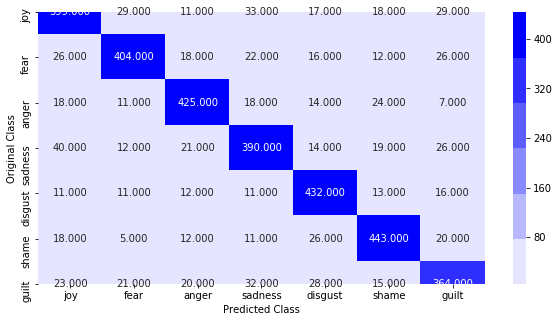

-------------------------------------------------- Precision matrix --------------------------------------------------


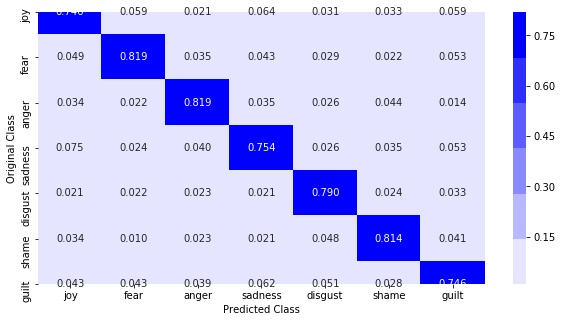

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


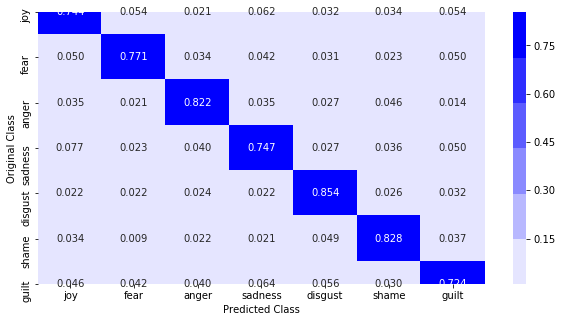

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1.]


In [45]:
plot_confusion_matrix(y_test,  y_predicted)